# KUONTOL KEJEPIT PROJECT

In [22]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torchvision import transforms
import os

#optional
import matplotlib.pyplot as plt

## LOAD DATASET

In [23]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [24]:
# Display first 5 rows of validation data
train_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [25]:
print(train_df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
No Finding                    float64
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
dtype: object


In [26]:
# Filter dataset untuk mengambil data dengan No indingF = 1.0
nofinding_filtered0 = train_df[train_df['No Finding'] == 1.0]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = 1.0):")
label_distribution = nofinding_filtered0.iloc[:, 5:].apply(pd.Series.value_counts, dropna=False)
label_distribution

Distribusi Data dari Semua Label (Filtered No Finding = 1.0):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0.0,NaN,8394.0,3350.0,2421.0,377.0,4461.0,8836.0,1158.0,483.0,13411.0,11450.0,20.0,1091.0,671
1.0,22381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8808
NaN,NaN,13987.0,19031.0,19960.0,22004.0,17920.0,13545.0,21223.0,21898.0,8970.0,10931.0,22361.0,21290.0,12792


In [27]:
# Filter dataset untuk mengambil data dengan No Finding = NaN
nofinding_filtered1 = train_df[pd.isna(train_df['No Finding'])]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = NaN):")
label_distribution = nofinding_filtered1.iloc[:, 5:].apply(pd.Series.value_counts, dropna=False)
label_distribution

Distribusi Data dari Semua Label (Filtered No Finding = NaN):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,12403,8087,5598,1488,12984,27742,18770,33739,3145,11628,2653,642,969
0.0,NaN,13244,7766,4178,893,16265,19261,1641,845,42930,23946,296,1421,5466
1.0,NaN,10798,27000,105581,9186,52246,14783,6039,33376,19448,86187,3523,9040,107193
NaN,201033.0,164588,158180,85676,189466,119538,139247,174583,133073,135510,79272,194561,189930,87405


Kesimpulannya adalah<br>
- JIKA `no finding` bernilai `1.0` MAKA pasien tidak memiliki penyakit atau semua penyakit bernilai `0.0` dan `nan`<br>
- JIKA `no finding` bernilai `nan` MAKA pasien memiliki penyakit `[1.0]` atau tidak memiliki penyakit `[0.0, nan]` atau ambigu `[0.5]`

<br>
Tabel dibawah ini menunjukan semua jenis label dan menandai bagian/data yang tidak diperlukan dalam penelitian ini.
<br>
<br>

| **Index**| **Label**                  | **Deskripsi**                              | **Data yang Tidak Diperlukan** |
|----------|----------------------------|--------------------------------------------|---|
| 0        | Path                       | Jalur file gambar X-ray                    |   |
| 1        | Sex                        | Jenis kelamin pasien (Laki-laki/Perempuan) | x |
| 2        | Age                        | Usia pasien                                | x |
| 3        | Frontal/Lateral            | Jenis tampilan X-ray (Frontal/Lateral)     | x |
| 4        | AP/PA                      | Jenis proyeksi (AP/PA/LL/RL)               | x |
| 5        | No Finding                 | Tidak ada kelainan ditemukan               |   |
| 6        | Enlarged Cardiomediastinum | Pembesaran area jantung dan mediastinum    |   |
| 7        | Cardiomegaly               | Pembesaran jantung                         |   |
| 8        | Lung Opacity               | Kekeruhan pada paru-paru                   |   |
| 9        | Lung Lesion                | Lesi atau massa di paru-paru               |   |
| 0        | Edema                      | Cairan berlebih di jaringan paru           |   |
| 11       | Consolidation              | Area padat di paru-paru                    |   |
| 12       | Pneumonia                  | Infeksi paru-paru                          |   |
| 13       | Atelectasis                | Kolaps parsial atau total paru-paru        |   |
| 14       | Pneumothorax               | Udara di rongga pleura                     |   |
| 15       | Pleural Effusion           | Cairan berlebih di rongga pleura           |   |
| 16       | Pleural Other              | Kelainan pleura lainnya                    |   |
| 17       | Fracture                   | Patah tulang                               |   |
| 18       | Support Devices            | Alat medis yang ada di gambar              |   |


Dari data tersebut nlai dari setiap jenis label dari rindext 6 hingga 18 memiliki nilai nan, -1.0, 0.0, dan 1.0
<br>

<!-- **Sex :**
- 0 = Female
- 1 = Male

**AP/PA :**
- 0 = AP (Antero-Posterior) Tidur atau duduk (sulit berdiri)
- 1 = PA (Postero-Anterior) Berdiri (standar)
- 2 = LL (Left Lateral) posisi pasien miring ke kiri
- 3 = RL (Right Lateral) posisi pasien miring ke kanan -->

- nan   : tidak diketahui (nilainya sama gengadn 0.0)
- -1.0  : ambigu
- 0.0   : tidak terdeteksi
- 1.0   : terdeteksi

In [28]:
# # Display label distribution
# print("\nLabel Distribution in Validation Data:")

# # Ensure consistent data types for all columns
# train_df_cleaned = train_df.apply(pd.to_numeric, errors='coerce')

# # Apply value_counts() to each column
# print(train_df_cleaned.apply(lambda x: x.value_counts(dropna=False)))

## PRE PROSESING

### Hapus data yang tidak diperlukam

In [29]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 
                   'Age', 
                   'Frontal/Lateral', 
                   'AP/PA',
                #    'No Finding'
                   ]
train_df = train_df.drop(columns=columns_to_drop)
valid_df = valid_df.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'] yang tidak diperlukan telah dihapus.


In [30]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count        Unique Values
No Finding                             1             1.0, nan
Enlarged Cardiomediastinum             3  nan, 0.0, 1.0, -1.0
Cardiomegaly                           3  nan, -1.0, 0.0, 1.0
Lung Opacity                           3  nan, 1.0, 0.0, -1.0
Lung Lesion                            3  nan, 1.0, -1.0, 0.0
Edema                                  3  nan, -1.0, 1.0, 0.0
Consolidation                          3  nan, -1.0, 0.0, 1.0
Pneumonia                              3  nan, 0.0, -1.0, 1.0
Atelectasis                            3  nan, -1.0, 1.0, 0.0
Pneumothorax                           3  0.0, nan, 1.0, -1.0
Pleural Effusion                       3  nan, -1.0, 0.0, 1.0
Pleural Other                          3  nan, 1.0, -1.0, 0.0
Fracture                               3  nan, 1.0, 0.0, -1.0
Support Devices                        3  1.0, nan, 0.0, -1.0


In [31]:
# Membuat dataset baru: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0
label_columns = train_df.columns[1:]  # kolom label (kecuali 'Path')
multi_label_array = []

for idx, row in train_df.iterrows():
    labels = [col for col in label_columns if row[col] == 1.0]
    multi_label_array.append({'Path': row['Path'], 'Labels': labels})

# Contoh hasil
for item in multi_label_array[:5]:
    print(f"{item['Path']} : {item['Labels']}")

CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg : ['No Finding', 'Support Devices']
CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg : ['Lung Opacity', 'Fracture']
CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg : ['Lung Opacity', 'Fracture']
CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg : ['Lung Opacity', 'Fracture']
CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg : ['Edema']


In [11]:
# Ubah nilai -1.0 menjadi 0.5 pada dataset train_df dan valid_df
train_df = train_df.replace(-1.0, 0.5)
valid_df = valid_df.replace(-1.0, 0.5)

print("Nilai -1.0 telah diubah menjadi 0.5 pada dataset.")

Nilai -1.0 telah diubah menjadi 0.5 pada dataset.


In [12]:
# Ubah nilai Nan menjadi 0.0 pada dataset train_df dan valid_df
train_df = train_df.replace(np.nan, 0.0)
valid_df = valid_df.replace(np.nan, 0.0)

print("Nilai Nan telah diubah menjadi 0.0 pada dataset.")

Nilai Nan telah diubah menjadi 0.0 pada dataset.


Dapat disimpulkan bahwa hasil distribusi label yang sudah di filtering 

In [13]:
# # Filter data dengan label 'Frontal'
# train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
# valid_df = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']

# print(f"Jumlah data dengan label 'Frontal' di train_df: {len(train_df)}")
# print(f"Jumlah data dengan label 'Frontal' di valid_df: {len(valid_df)}")

### LABEL ENCODING

## KORELASI (train)

Tabel Korelasi:


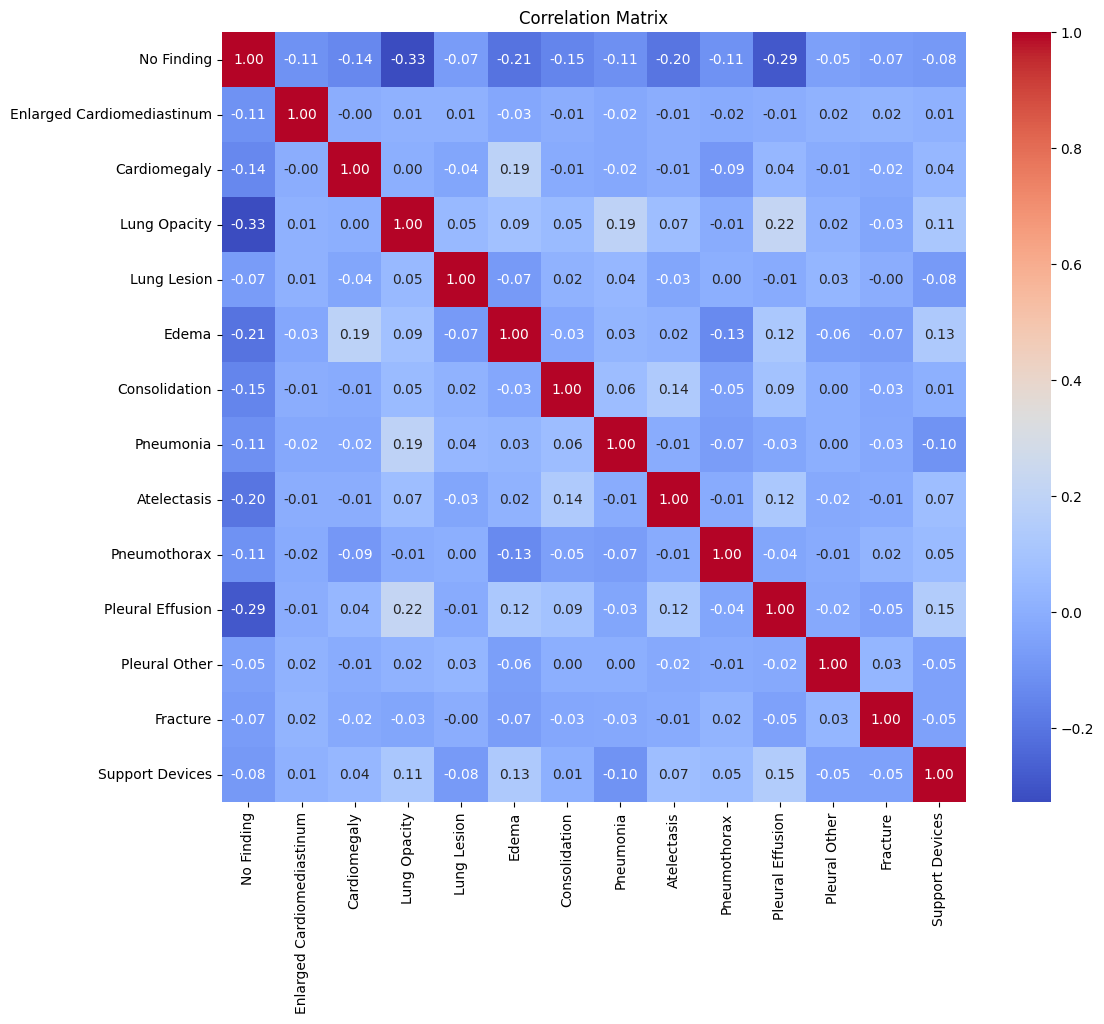

In [21]:
import seaborn as sns

# Hitung korelasi antar kolom pada dataset train_df (hanya kolom numerik)
numeric_columns = train_df.select_dtypes(include=['number'])
correlation_table = numeric_columns.corr()

# Tampilkan tabel korelasi
print("Tabel Korelasi:")
import matplotlib.pyplot as plt

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

## MENYIAPKAN DATASET

### Membuat Data Test dari Data Valid

In [15]:
# Bagi valid_df menjadi validasi dan test set
valid_df, test_df = train_test_split(valid_df, test_size=0.2, random_state=42)
print("valid_df menjadi validasi dan test set")

valid_df menjadi validasi dan test set


In [16]:
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validasi: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}\n")

Jumlah data train: 223414
Jumlah data validasi: 187
Jumlah data test: 47



# TRAIN

In [18]:
from transformers import ViTForImageClassification, ViTConfig

# Konfigurasi model Vision Transformer
config = ViTConfig(
    image_size=224,  # Ukuran input gambar (224x224)
    num_labels=14,   # Jumlah label output (disesuaikan dengan dataset)
    hidden_size=768, # Ukuran dimensi hidden layer
    num_hidden_layers=12, # Jumlah layer transformer
    num_attention_heads=12, # Jumlah head pada multi-head attention
    intermediate_size=3072, # Ukuran layer intermediate
    patch_size=16,    # Ukuran patch gambar
    hidden_dropout_prob=0.1, # Dropout pada hidden layer
    attention_probs_dropout_prob=0.1, # Dropout pada attention
)

# Membuat model Vision Transformer
model = ViTForImageClassification(config)

# Menampilkan arsitektur model
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [20]:
from transformers import ViTFeatureExtractor

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=14
)

print("Pre-trained ViT model dan feature extractor telah dimuat.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pre-trained ViT model dan feature extractor telah dimuat.


In [ ]:
# Definisikan transformasi gambar
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Ubah ukuran gambar menjadi 224x224
    transforms.ToTensor(),          # Konversi gambar menjadi tensor
    transforms.Normalize(           # Normalisasi gambar dengan mean dan std
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

print("Transformasi gambar telah ditambahkan.")

Transformasi gambar telah ditambahkan.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CheXpertDataset(Dataset):
     def __init__(self, df, transform):
          self.df = df
          self.transform = transform

     def __len__(self):
          return len(self.df)

     def __getitem__(self, idx):
          img_path = 'datasets/' + self.df.iloc[idx]['Path']
          image = Image.open(img_path).convert('RGB')
          image = self.transform(image)
          label = torch.tensor(self.df.iloc[idx, 1:].values.astype(np.float32))
          return image, label

# DataLoader
train_dataset = CheXpertDataset(train_df, image_transforms)
valid_dataset = CheXpertDataset(valid_df, image_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)



In [ ]:
# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
# Asymmetric Loss implementation
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, logits, targets):
        x_sigmoid = torch.sigmoid(logits)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        loss_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(xs_neg.clamp(min=self.eps))
        loss = loss_pos + loss_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = xs_pos * targets
            pt1 = xs_neg * (1 - targets)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
            loss *= (1 - pt) ** one_sided_gamma

        return -loss.mean()

criterion = AsymmetricLoss()

In [ ]:
# Training loop (sederhana)
epochs = 5
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print("anjay")
    print(f"Epoch [{epoch+1}/{epochs}] selesai, Loss terakhir: {loss.item():.4f}")

    # Validasi
    model.eval()
    val_losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    avg_val_loss = np.mean(val_losses)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    # Hitung akurasi untuk setiap label
    accuracies = []
    for i in range(all_labels.shape[1]):
        acc = accuracy_score(all_labels[:, i], (all_preds[:, i] > 0.5).astype(int))
        accuracies.append(acc)
        print(f"Label {i}: Accuracy = {acc:.4f}")
    
    # Hitung AUC untuk setiap label
    auc_scores = []
    for i in range(all_labels.shape[1]):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        except ValueError:
            auc = float('nan')
        auc_scores.append(auc)
        print(f"Label {i}: AUC = {auc:.4f}")

    # Simpan model
    torch.save(model.state_dict(), f'vit_model_epoch_{epoch}.pth')
    
    # Simpan hasil validasi ke CSV
    val_results = pd.DataFrame(all_preds, columns=train_df.columns[1:])
    val_results['epoch'] = epoch
    val_results['avg_val_loss'] = avg_val_loss
    val_results.to_csv(f'val_results_epoch_{epoch}.csv', index=False)
    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

print("Fine-tuning selesai.")


anjay


KeyboardInterrupt: 

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Membaca hasil validasi dari salah satu file CSV hasil training
val_results = pd.read_csv('val_results_epoch_0.csv')

# Plot distribusi prediksi untuk setiap label
plt.figure(figsize=(14, 6))
val_results.drop(['epoch', 'avg_val_loss'], axis=1).mean().plot(kind='bar')
plt.title('Rata-rata Prediksi Setiap Label (Epoch 0)')
plt.ylabel('Rata-rata Prediksi')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()